- Figure 4e : Normal OPC vs GFP(+) OPC
- Figure 4f : GFP (+) OPC vs GFP(+) Tumor
- Gene sets
  - GO : biological process
  - KEGG
  - REACTOME
  - MouseMine
- ORA -> GSEA

In [67]:
import os
from pathlib import Path
import warnings
import random
warnings.filterwarnings('ignore')

import scanpy as sc
import numpy as np
import pandas as pd
import decoupler as dc

import mplscience
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

import gseapy as gp

seed = 777

In [170]:
def do_pseudobulk(adata, condition, contrast=None, seed=42):
    """
    Create pseudobulk data from single-cell RNA sequencing data.
    
    Parameters:
    -----------
    adata : AnnData
        Annotated data matrix
    condition : str
        Column name in adata.obs for primary condition
    contrast : str, optional
        Additional column name for covariate analysis
    seed : int, default=42
        Random seed for reproducibility
    
    Returns:
    --------
    pb : AnnData
        Pseudobulk data
    dds : DESeqDataSet
        DESeq2 dataset
    de : DataFrame
        Differential expression results
    fig : Figure
        PCA plot
    """
    if condition not in adata.obs.columns:
        raise ValueError(f"Condition '{condition}' not found in adata.obs")
    if contrast and contrast not in adata.obs.columns:
        raise ValueError(f"Contrast '{contrast}' not found in adata.obs")
        
    pseudobulk = []
    random.seed(seed)
    
    for sample in adata.obs.sample_id.unique():
        sample_cells = adata[adata.obs['sample_id'] == sample]
        
        # Create 3 pseudo-replicates
        idx = np.array_split(
            np.random.permutation(sample_cells.obs_names), 
            3
        )
        
        for i, split_idx in enumerate(idx):
            if len(split_idx) == 0:
                continue
                
            rep_adata = sc.AnnData(
                X=sample_cells[split_idx].X.sum(axis=0),
                var=sample_cells.var
            )
            rep_adata.obs_names = [f"{sample}-{i}"]
            rep_adata.obs['condition'] = sample_cells.obs[condition].iloc[0]
            rep_adata.obs['replicate'] = i
            
            if contrast:
                rep_adata.obs[contrast] = (
                    sample_cells.obs[contrast].mean() 
                    if pd.api.types.is_numeric_dtype(sample_cells.obs[contrast])
                    else sample_cells.obs[contrast].iloc[0]
                )
                
            pseudobulk.append(rep_adata)
    
    pb = sc.concat(pseudobulk)
    
    # DESeq2 analysis
    design_factors = [x for x in [contrast, 'condition'] if x is not None]
    dds = DeseqDataSet(
        counts=pd.DataFrame(pb.X, columns=pb.var_names),
        metadata=pb.obs,
        design_factors=design_factors,
        refit_cooks=True,
        inference=DefaultInference(),
        n_cpus=None
    )
    
    sc.pp.filter_genes(dds, min_cells=1)
    dds.deseq2()
    
    # Visualization
    sc.tl.pca(dds, layer="normed_counts")
    fig = sc.pl.pca(dds, color='condition', size=200, show=False)
    
    # Differential expression
    stat_res = DeseqStats(dds, inference=DefaultInference())
    stat_res.summary()
    
    return pb, dds, stat_res.results_df, fig

In [69]:
msigdb = dc.get_resource('MSigDB', organism = 'mouse')

In [70]:
collections = msigdb['collection'].unique()
for idx, collection in enumerate(collections, 1):
    print(f"{idx}. {collection}")

# hallmark
# kegg_pathways
# go_biological_process
# reactome_pathways

## additional
# oncogenic_signatures
# cell_type_signatures = annotation?
# cancer_modules

1. chemical_and_genetic_perturbations
2. immunesigdb
3. mirna_targets_mirdb
4. go_molecular_function
5. tf_targets_gtrf
6. tf_targets_legacy
7. oncogenic_signatures
8. cell_type_signatures
9. vaccine_response
10. go_biological_process
11. cancer_gene_neighborhoods
12. cancer_modules
13. go_cellular_component
14. wikipathways
15. reactome_pathways
16. hallmark
17. mirna_targets_legacy
18. biocarta_pathways
19. positional
20. human_phenotype_ontology
21. pid_pathways
22. kegg_pathways


In [71]:
query = 'hallmark'
db = msigdb[msigdb['collection']==query]

db = db[~db.duplicated(['geneset', 'genesymbol'])]
db.dropna(inplace = True)

# 1. Fig 4e

In [171]:
adata = sc.read_h5ad('../output/reannotated.h5ad')
adata = adata[adata.obs['cell_type'] == 'OPC'].copy()
adata.obs['condition'] = adata.obs['sample_id'].apply(lambda x: 'Tumor' if x.startswith('Mouse') else 'Normal')
adata.obs.condition = adata.obs.condition.astype('category')
cond = ((adata.obs['GFP'] == 'GFP+') & (adata.obs.condition == 'Tumor')) | ((adata.obs['GFP'] == 'GFP-') & (adata.obs.condition == 'Normal'))
adata = adata[:, adata.var_names != 'Cas9-EGFP'].copy()
adata = adata[cond].copy()
sc.pp.filter_genes(adata, min_cells = int(adata.shape[0]*0.1))
adata

AnnData object with n_obs × n_vars = 10553 × 9594
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type', 'condition'
    var: 'n_cells'
    uns: 'cell_type_colors', 'leiden', 'neighbors', 'sample_info_colors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts', 'log1p'
    obsp: 'connectivities', 'distances'

In [172]:
adata.obs.condition.value_counts()

condition
Normal    9536
Tumor     1017
Name: count, dtype: int64

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.43 seconds.

Fitting dispersion trend curve...
... done in 0.09 seconds.

Fitting MAP dispersions...
... done in 0.39 seconds.

Fitting LFCs...
... done in 0.51 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 7 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition Tumor vs Normal
                  baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0610009B22Rik    30.908576        0.423951  0.207598  2.042174  4.113423e-02   
0610009L18Rik    11.815447       -0.515102  0.286841 -1.795774  7.253050e-02   
0610010K14Rik    33.543960        0.302619  0.229743  1.317209  1.877685e-01   
0610030E20Rik    16.882638        0.235717  0.134370  1.754241  7.938923e-02   
0610040J01Rik   107.014987       -1.066672  0.175702 -6.070902  1.271936e-09   
...                    ...             ...       ...       ...           ...   
mt-Nd3          230.472977       -1.291380  0.327873 -3.938658  8.193870e-05   
mt-Nd4         1304.379208       -0.569246  0.215642 -2.639779  8.296007e-03   
mt-Nd4l         112.063105       -1.860626  0.234264 -7.942442  1.982386e-15   
mt-Nd5          146.810680       -0.681293  0.111185 -6.127563  8.923540e-10   
mt-Nd6           25.630669        0.052457  0.205849  0.

... done in 0.26 seconds.



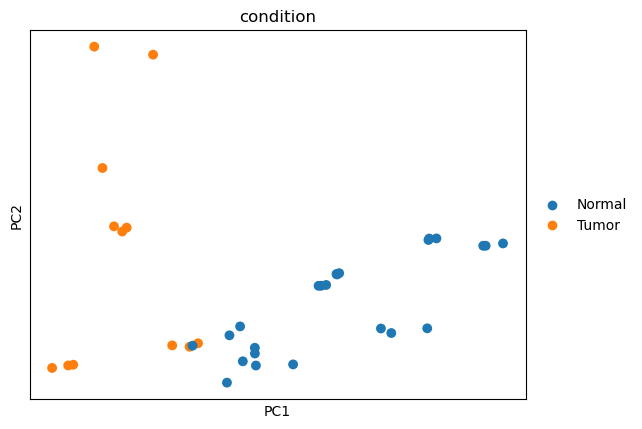

In [173]:
pb, dds, de, fig = do_pseudobulk(adata, 'condition')

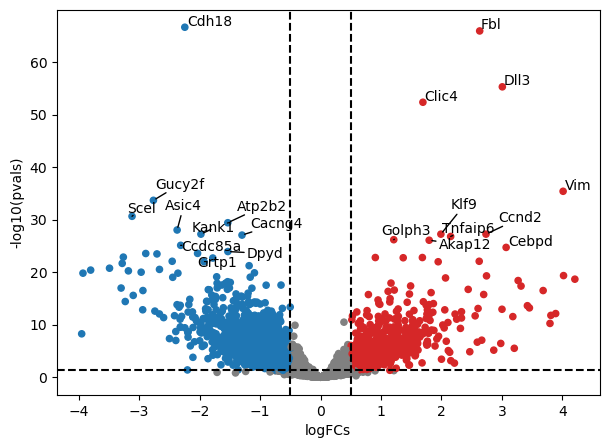

In [174]:
dc.plot_volcano_df(de, x='log2FoldChange', y='padj', top = 20, )

## ORA

In [76]:
db['geneset'] = db['geneset'].apply(
    lambda x: x.split('_', 1)[1] if isinstance(x, str) and '_' in x else x
)

In [77]:
top_genes = de[de['padj'] < 0.05].copy()

enriched = dc.get_ora_df(df = top_genes, net = db, source = 'geneset', target = 'genesymbol')
enriched.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ADIPOGENESIS,171,0.356725,0.000562,0.005615,1.480044,11.077913,Abcb8;Acox1;Adipor2;Agpat3;Ak2;Aldh2;Atp1b3;Ca...
1,ALLOGRAFT_REJECTION,174,0.195402,0.944211,0.997596,0.811312,0.046574,Abce1;Ache;Akt1;B2m;Bcat1;Bcl10;Ccnd2;Ccnd3;De...
2,ANDROGEN_RESPONSE,95,0.336842,0.024976,0.083253,1.401494,5.171296,Abhd2;Acsl3;Adamts1;Akap12;Akt1;Appbp2;B2m;Cam...
3,ANGIOGENESIS,33,0.181818,0.848459,0.997596,0.797261,0.131017,App;Ccnd2;Lrpap1;Pdgfa;Ptk2;S100a4
4,APICAL_JUNCTION,163,0.331288,0.006784,0.056532,1.374312,6.862235,Actg1;Adam15;Adam23;Atp1a3;Baiap2;Cadm3;Calb2;...


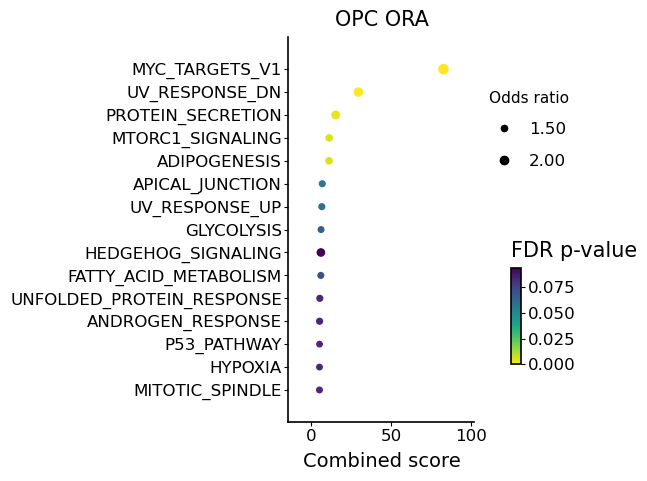

In [78]:
with mplscience.style_context():
    dc.plot_dotplot(
        enriched.sort_values('Combined score', ascending=False).head(15),
        x='Combined score',
        y='Term',
        s='Odds ratio',
        c='FDR p-value',
        scale=0.5,
        title= "OPC ORA"
    )
    plt.grid(False)


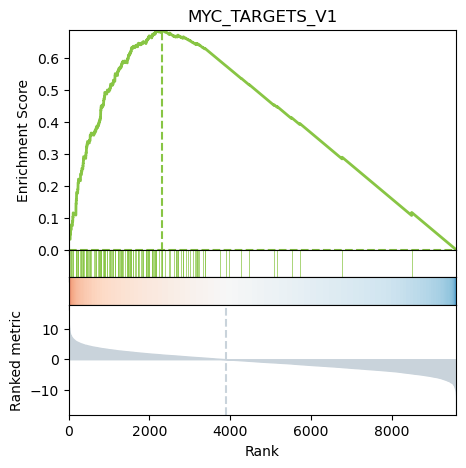

In [79]:
dc.plot_running_score(
    df=de,
    stat='stat',
    net=db,
    source='geneset',
    target='genesymbol',
    set_name='MYC_TARGETS_V1'
)

## Progeny

In [80]:
progeny = dc.get_progeny(top=1000, organism = "mouse")
progeny

,source,target,weight,p_value
0,Androgen,Tmprss2,11.490631,0.000000e+00
1,Androgen,Nkx3-1,10.622551,2.242078e-44
2,Androgen,Mboat2,10.472733,4.624285e-44
3,Androgen,Sarg,11.386852,2.790209e-40
4,Androgen,Slc38a4,7.363805,1.253072e-39
...,...,...,...,...
13995,p53,Fanci,-3.962874,2.598821e-04
13996,p53,Ywhae,-1.924218,2.604428e-04
13997,p53,Elovl5,-1.287946,2.623710e-04
13998,p53,Naalad2,-1.035270,2.640760e-04


In [81]:
mat = de[['stat']].T.rename(index={'stat': 'OPC'})
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)

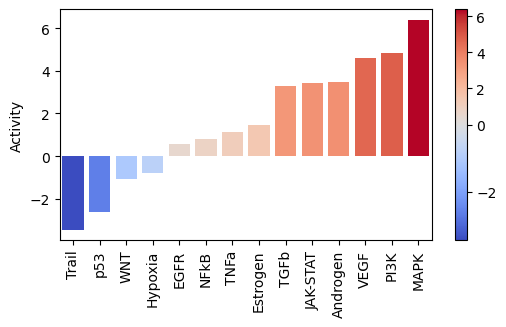

In [82]:
dc.plot_barplot(
    acts=pathway_acts,
    contrast='OPC',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

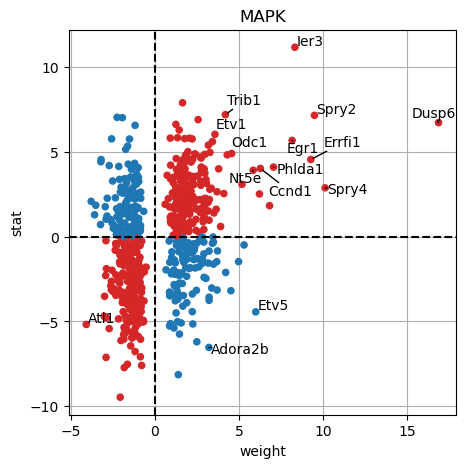

In [83]:
dc.plot_targets(
    data=de,
    stat='stat',
    source_name='MAPK',
    net=progeny,
    top=15
)

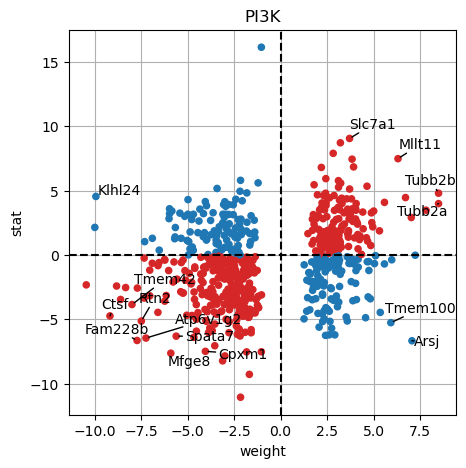

In [84]:
dc.plot_targets(
    data=de,
    stat='stat',
    source_name='PI3K',
    net=progeny,
    top=15
)

## GSEA

In [85]:
de['rank'] = -np.log10(de.padj) * de.log2FoldChange
de = de.sort_values('rank', ascending=False)
de['gene'] = de.index

In [86]:
rnk = de[['gene', 'rank']].reset_index(drop=True).copy()

In [87]:
gene_sets = db[['geneset', 'genesymbol']].groupby('geneset').agg(lambda x: x.tolist()).to_dict()['genesymbol']
gene_sets = {k: v for k, v in gene_sets.items() if v}

In [88]:
pre_res = gp.prerank(rnk = rnk, gene_sets = gene_sets, seed = seed, threads=16, permutation_num=10000)

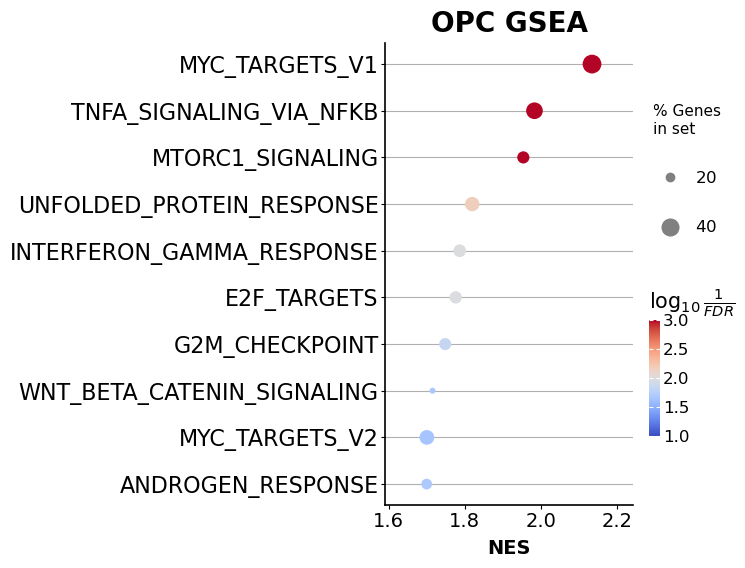

In [89]:
with mplscience.style_context():
    gp.dotplot(pre_res.res2d, column = 'FDR q-val', title = "OPC GSEA", cmap = 'coolwarm')

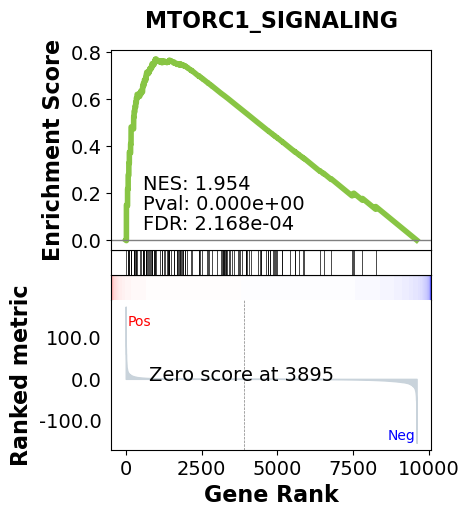

In [90]:
pre_res.plot(terms = pre_res.res2d.Term[2])
plt.show()
plt.close()

# 2. Fig 4f

In [144]:
def do_pseudobulk(adata, condition, reference, seed=777):
    pseudobulk = []
    random.seed(seed)
    
    # Process each condition separately
    for cond in adata.obs[condition].unique():
        # Get subset for this condition
        condition_subset = adata[adata.obs[condition] == cond]
        
        # Process each sample within this condition
        for sample in condition_subset.obs.sample_id.unique():
            sample_subset = condition_subset[condition_subset.obs['sample_id'] == sample]
            
            # Create random splits
            idx = list(sample_subset.obs_names)
            random.shuffle(idx)
            idx = np.array_split(np.array(idx), 3)
            
            # Create pseudobulk replicates
            for i, split_idx in enumerate(idx):
                if len(split_idx) > 0:  # Only create replicate if cells exist
                    rep_adata = sc.AnnData(X=sample_subset[split_idx].X.sum(axis=0).reshape(1,-1),
                                         var=sample_subset.var)
                    rep_adata.obs_names = [f"{sample}-{cond}-{i}"]
                    rep_adata.obs['condition'] = cond
                    rep_adata.obs['replicate'] = i
                    rep_adata.obs['sample_id'] = sample
                    pseudobulk.append(rep_adata)
    
    pb = sc.concat(pseudobulk)
    counts_df = pd.DataFrame(pb.X, columns=pb.var_names)
    
    dds = DeseqDataSet(
        counts=counts_df,
        metadata=pb.obs,
        design_factors=['condition'],
        ref_level=['condition', reference],
        refit_cooks=True,
        inference=DefaultInference(),
        n_cpus=None
    )
    
    sc.pp.filter_genes(dds, min_cells=1)
    dds.deseq2()
    sc.tl.pca(dds, layer="normed_counts")
    fig = sc.pl.pca(dds, color='condition', size=200, show=False)
    
    stat_res = DeseqStats(dds, inference=DefaultInference())
    stat_res.summary()
    
    return dds, stat_res.results_df, fig

In [127]:
adata = sc.read_h5ad('../output/reannotated.h5ad')
adata = adata[adata.obs['GFP'] == 'GFP+'].copy()
adata = adata[adata.obs['cell_type'].isin(['OPC', 'Tumor']) & adata.obs.sample_id.isin(['Mouse1', 'Mouse2', 'Mouse3', 'Mouse4'])].copy()
adata.obs.cell_type = adata.obs.cell_type.cat.remove_unused_categories()
adata.obs.cell_type = adata.obs.cell_type.cat.reorder_categories(['OPC', 'Tumor'])
adata = adata[:, adata.var_names != 'Cas9-EGFP'].copy()
sc.pp.filter_genes(adata, min_cells = int(adata.shape[0]*0.1))
adata

AnnData object with n_obs × n_vars = 10012 × 10881
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type'
    var: 'n_cells'
    uns: 'cell_type_colors', 'leiden', 'neighbors', 'sample_info_colors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts', 'log1p'
    obsp: 'connectivities', 'distances'

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.49 seconds.

Fitting dispersion trend curve...
... done in 0.12 seconds.

Fitting MAP dispersions...
... done in 0.45 seconds.

Fitting LFCs...
... done in 0.42 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 19 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition Tumor vs OPC
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610009B22Rik    51.359548       -0.410800  0.224647 -1.828644  0.067453   
0610009L18Rik     9.795659       -0.910743  0.376680 -2.417813  0.015614   
0610010K14Rik    70.957560        0.473972  0.123558  3.836034  0.000125   
0610030E20Rik    30.710066       -0.255165  0.147155 -1.733983  0.082921   
0610040J01Rik    89.095901       -0.968247  0.229604 -4.217022  0.000025   
...                    ...             ...       ...       ...       ...   
mt-Nd3          207.710814        0.028670  0.129067  0.222129  0.824214   
mt-Nd4         1685.453206       -0.010429  0.122720 -0.084978  0.932279   
mt-Nd4l          75.102441       -0.084121  0.318651 -0.263992  0.791786   
mt-Nd5          193.438355        0.185471  0.119585  1.550957  0.120912   
mt-Nd6           46.401640       -0.325416  0.284196 -1.145041  0.252192   

                   padj  


... done in 0.29 seconds.



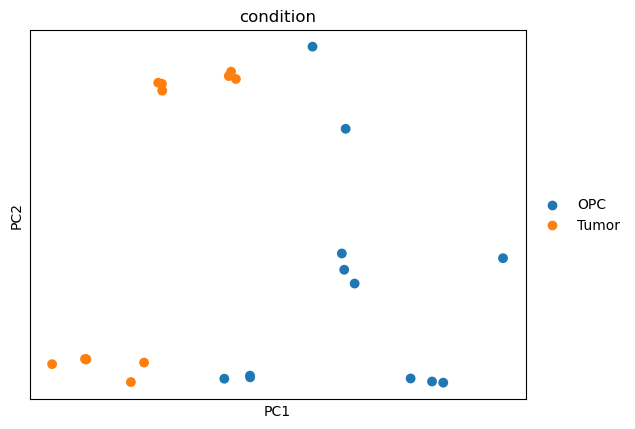

In [145]:
dds, de, fig = do_pseudobulk(adata, 'cell_type', 'OPC')

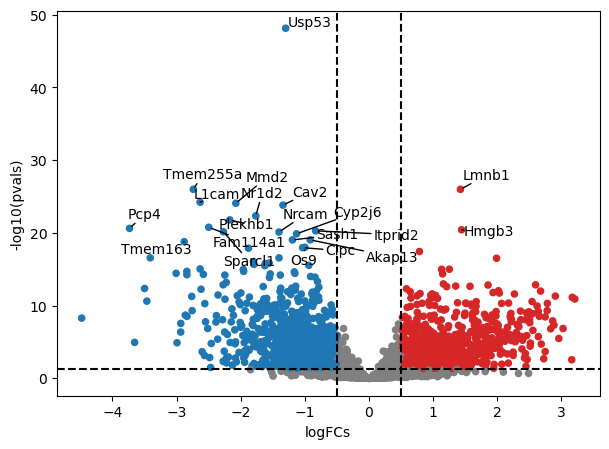

In [146]:
dc.plot_volcano_df(de, x='log2FoldChange', y='padj', top = 20)

## ORA

In [147]:
top_genes = de[de['padj'] < 0.05].copy()

enriched = dc.get_ora_df(df = top_genes, net = db, source = 'geneset', target = 'genesymbol')
enriched.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ADIPOGENESIS,171,0.210526,0.045025,0.109610,1.339982,4.154665,Acox1;Agpat3;Ak2;Aldh2;Apoe;Arl4a;Bcl6;Cd151;C...
1,ALLOGRAFT_REJECTION,174,0.120690,0.937562,0.978895,0.771941,0.049769,Abce1;Brca1;Ccnd2;Ccnd3;Degs1;Eif5a;Ifngr1;Inh...
2,ANDROGEN_RESPONSE,95,0.210526,0.111990,0.233312,1.349837,2.955264,Abhd2;Actn1;Ccnd3;Cenpn;Dnajb9;Fads1;Gucy1a1;I...
3,ANGIOGENESIS,33,0.151515,0.621496,0.776870,1.030733,0.490243,Ccnd2;Fgfr1;Itgav;Lrpap1;Pdgfa
4,APICAL_JUNCTION,163,0.147239,0.695151,0.847745,0.940247,0.341898,Actn1;Adam15;Adam23;Adamts5;Arpc2;Baiap2;Cadm3...


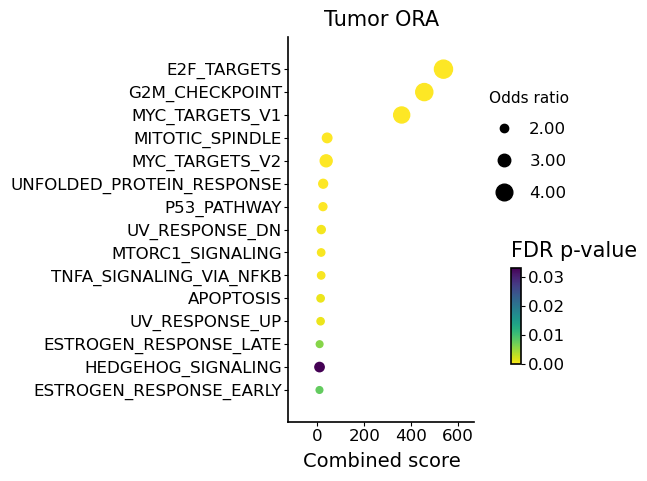

In [148]:
with mplscience.style_context():
    dc.plot_dotplot(
        enriched.sort_values('Combined score', ascending=False).head(15),
        x='Combined score',
        y='Term',
        s='Odds ratio',
        c='FDR p-value',
        scale=0.5,
        title= "Tumor ORA"
    )
    plt.grid(False)


## Progeny

In [149]:
mat = de[['stat']].T.rename(index={'stat': 'OPC'})
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)

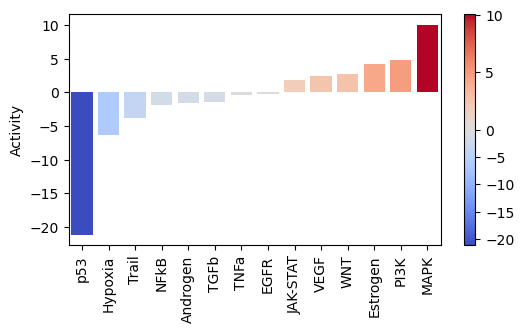

In [150]:
dc.plot_barplot(
    acts=pathway_acts,
    contrast='OPC',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

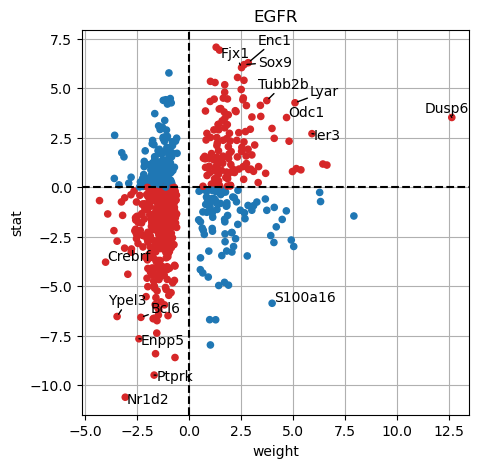

In [151]:
dc.plot_targets(
    data=de,
    stat='stat',
    source_name='EGFR',
    net=progeny,
    top=15
)

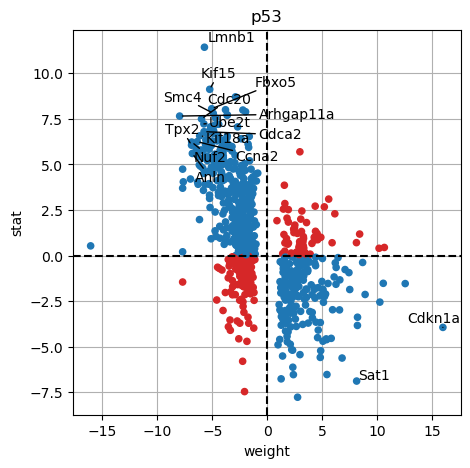

In [152]:
dc.plot_targets(
    data=de,
    stat='stat',
    source_name='p53',
    net=progeny,
    top=15
)

## GSEA
- hallmark, go_biological_process, kegg_pathways, reactome_pathways, oncogenic_signatures

In [161]:
query = 'go_biological_process'
db = msigdb[msigdb['collection']==query]

db = db[~db.duplicated(['geneset', 'genesymbol'])]
db.dropna(inplace = True)

In [162]:
db['geneset'] = db['geneset'].apply(
    lambda x: x.split('_', 1)[1] if isinstance(x, str) and '_' in x else x
)

In [163]:
de['rank'] = -np.log10(de.padj) * de.log2FoldChange
de = de.sort_values('rank', ascending=False)
de['gene'] = de.index

In [164]:
rnk = de[['gene', 'rank']].reset_index(drop=True).copy()

In [165]:
gene_sets = db[['geneset', 'genesymbol']].groupby('geneset').agg(lambda x: x.tolist()).to_dict()['genesymbol']
gene_sets = {k: v for k, v in gene_sets.items() if v}

In [166]:
pre_res = gp.prerank(rnk = rnk, gene_sets = gene_sets, seed = seed, threads=16, permutation_num=10000)

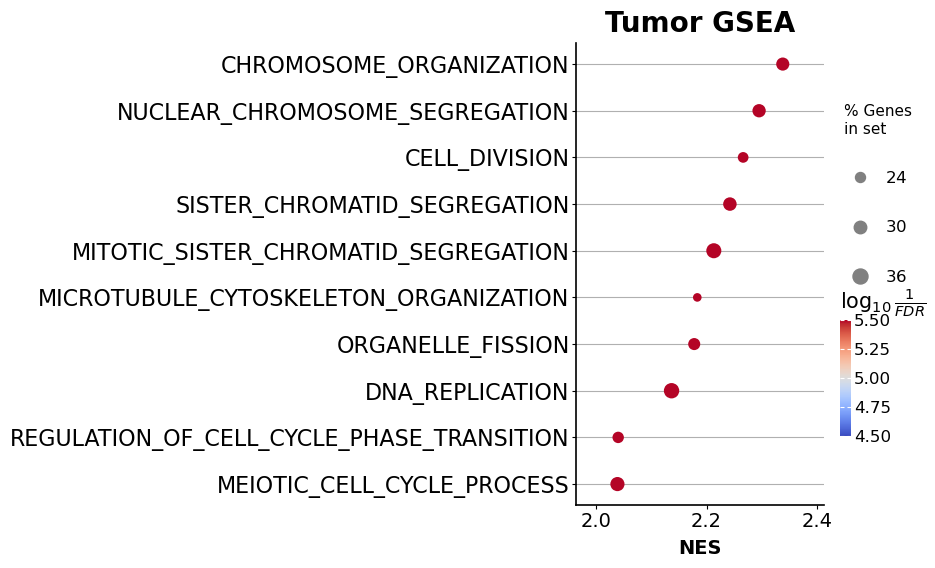

In [167]:
with mplscience.style_context():
    gp.dotplot(pre_res.res2d, column = 'FDR q-val', title = "Tumor GSEA", cmap = 'coolwarm', )

# 2 - 2. Fig 4f : OPC vs Tumor (in mouse, no GFP filter)

In [50]:
adata = sc.read_h5ad('../output/annotated.h5ad')
adata = adata[adata.obs['cell_type'].isin(['OPC', 'Tumor']) & adata.obs.sample_id.isin(['Mouse1', 'Mouse2', 'Mouse3', 'Mouse4'])].copy()
adata.obs.cell_type = adata.obs.cell_type.cat.remove_unused_categories()
adata.obs.cell_type = adata.obs.cell_type.cat.reorder_categories(['OPC', 'Tumor'])
adata = adata[:, adata.var_names != 'Cas9-EGFP'].copy()
sc.pp.filter_genes(adata, min_cells = int(adata.shape[0]*0.1))
adata

AnnData object with n_obs × n_vars = 17643 × 10593
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type'
    var: 'n_cells'
    uns: 'each_cell_type_colors', 'neighbors', 'sample_info_colors', 'umap'
    obsm: 'X_pca', 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts', 'log1p'
    obsp: 'connectivities', 'distances'

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.41 seconds.

Fitting dispersion trend curve...
... done in 0.14 seconds.

Fitting MAP dispersions...
... done in 0.47 seconds.

Fitting LFCs...
... done in 0.34 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: condition Tumor vs OPC
                   baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0610009B22Rik    556.939254       -0.180316  0.290495 -0.620720  5.347840e-01   
0610010K14Rik    880.947005        0.057168  0.126959  0.450288  6.525025e-01   
0610030E20Rik    310.330215       -0.160900  0.123697 -1.300759  1.933409e-01   
0610040J01Rik    688.695489       -0.887615  0.137246 -6.467328  9.975100e-11   
1110002L01Rik    146.274345        0.089859  0.189288  0.474719  6.349869e-01   
...                     ...             ...       ...       ...           ...   
mt-Nd3          2071.439571       -0.129640  0.156499 -0.828376  4.074579e-01   
mt-Nd4         17841.764882        0.062044  0.061243  1.013079  3.110227e-01   
mt-Nd4l          732.255796       -0.567646  0.329900 -1.720663  8.531198e-02   
mt-Nd5          2009.884262       -0.086697  0.126109 -0.687474  4.917839e-01   
mt-Nd6           363.812465       -0.725150  0.2

... done in 0.27 seconds.



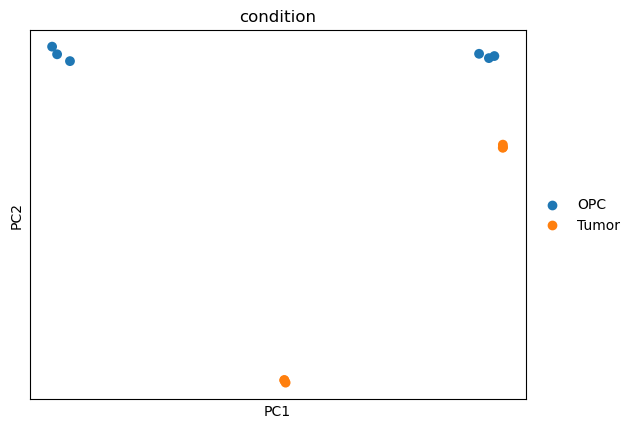

In [51]:
dds, de, fig = do_pseudobulk(adata, 'cell_type', 'OPC')

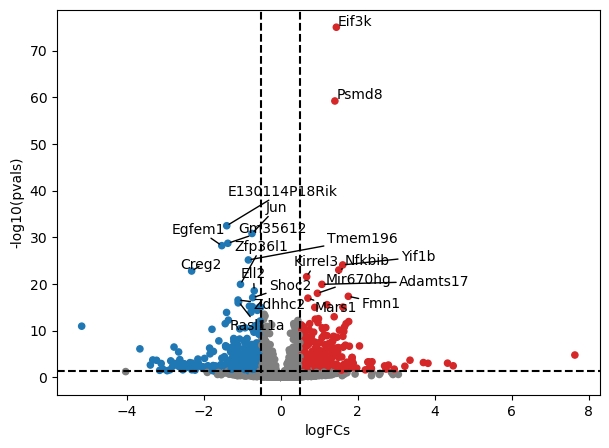

In [52]:
dc.plot_volcano_df(de, x='log2FoldChange', y='padj', top = 20)

## ORA

In [53]:
top_genes = de[de['padj'] < 0.05].copy()

enriched = dc.get_ora_df(df = top_genes, net = db, source = 'geneset', target = 'genesymbol')
enriched.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ADIPOGENESIS,171,0.233918,7.698350e-07,0.000018,2.282607,32.132463,Acaa2;Acox1;Ak2;Apoe;Cat;Cd302;Cs;Cyc1;Dbt;Dec...
1,ALLOGRAFT_REJECTION,174,0.080460,8.815267e-01,0.963529,0.793008,0.099998,B2m;Bcat1;Bcl3;Csk;Eif3d;Eif3j1;Eif5a;Ets1;Glm...
2,ANDROGEN_RESPONSE,95,0.221053,6.871452e-04,0.005622,2.164377,15.763083,Abcc4;Adrm1;Appbp2;Arid5b;B2m;Camkk2;Dnajb9;El...
3,APICAL_JUNCTION,163,0.134969,1.274824e-01,0.205051,1.319126,2.717105,Actb;Bmp1;Cap1;Cldn11;Col16a1;Evl;Fbn1;Gnai1;I...
4,APOPTOSIS,145,0.193103,9.956954e-04,0.006685,1.884769,13.027656,Bcap31;Bnip3l;Cav1;Cdc25b;Ctnnb1;Cyld;Ddit3;Dn...


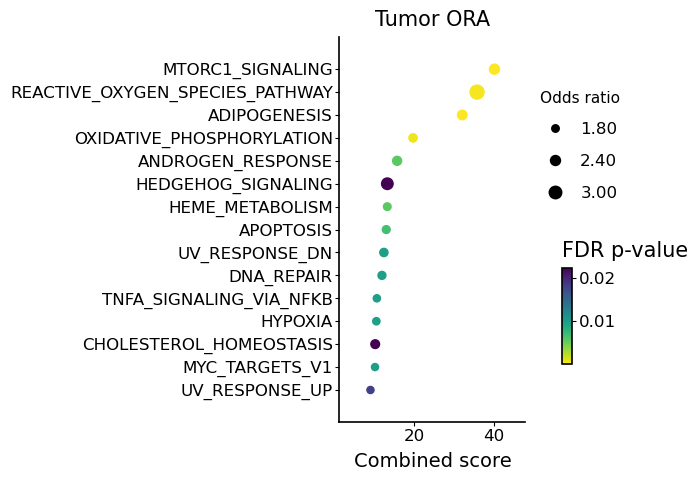

In [54]:
with mplscience.style_context():
    dc.plot_dotplot(
        enriched.sort_values('Combined score', ascending=False).head(15),
        x='Combined score',
        y='Term',
        s='Odds ratio',
        c='FDR p-value',
        scale=0.5,
        title= "Tumor ORA"
    )
    plt.grid(False)


## Progeny

In [55]:
mat = de[['stat']].T.rename(index={'stat': 'OPC'})
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)

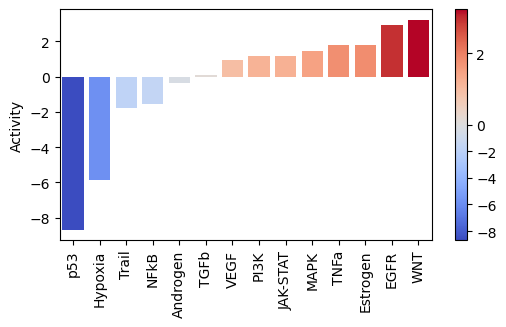

In [56]:
dc.plot_barplot(
    acts=pathway_acts,
    contrast='OPC',
    top=25,
    vertical=False,
    figsize=(6, 3)
)

## GSEA

In [59]:
query = 'hallmark'
db = msigdb[msigdb['collection']==query]

db = db[~db.duplicated(['geneset', 'genesymbol'])]
db.dropna(inplace = True)

In [60]:
db['geneset'] = db['geneset'].apply(
    lambda x: x.split('_', 1)[1] if isinstance(x, str) and '_' in x else x
)

In [61]:
de['rank'] = -np.log10(de.padj) * de.log2FoldChange
de = de.sort_values('rank', ascending=False)
de['gene'] = de.index

In [62]:
rnk = de[['gene', 'rank']].reset_index(drop=True).copy()

In [63]:
gene_sets = db[['geneset', 'genesymbol']].groupby('geneset').agg(lambda x: x.tolist()).to_dict()['genesymbol']
gene_sets = {k: v for k, v in gene_sets.items() if v}

In [64]:
pre_res = gp.prerank(rnk = rnk, gene_sets = gene_sets, seed = seed, threads=16, permutation_num=10000)

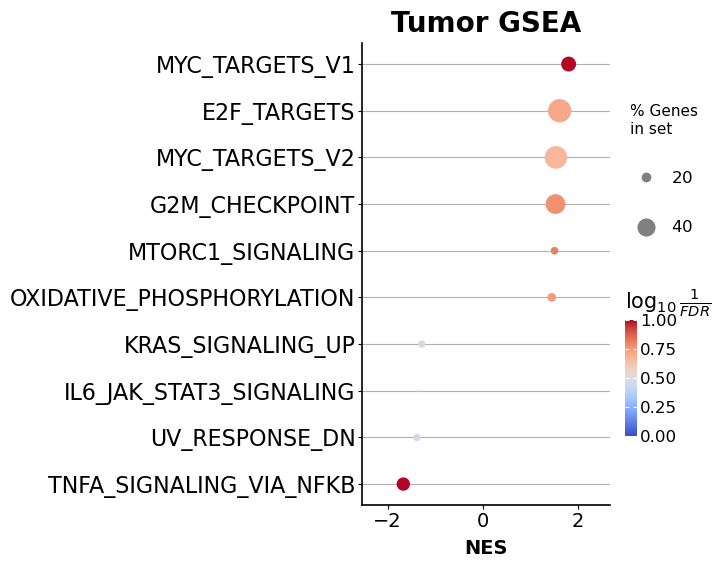

In [66]:
with mplscience.style_context():
    gp.dotplot(pre_res.res2d, column = 'FDR q-val', title = "Tumor GSEA", cmap = 'coolwarm', cutoff = 0.5)